In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

In [167]:
# connect the database
sql = sqlite3.connect('./data/FPA_FOD_20170508.sqlite')

In [168]:
# create dataframe fome the database
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", sql)

In [169]:
data = df.copy()
data.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [170]:
# convert date from julian formate to gregorian dates
data['DATE'] = pd.to_datetime(data['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [171]:
# to get month and dow from date
data['MONTH'] = pd.DatetimeIndex(wf['DATE']).month
data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek
rf_data = data.copy()

Text(0.5, 1.0, 'Causes of Fires')

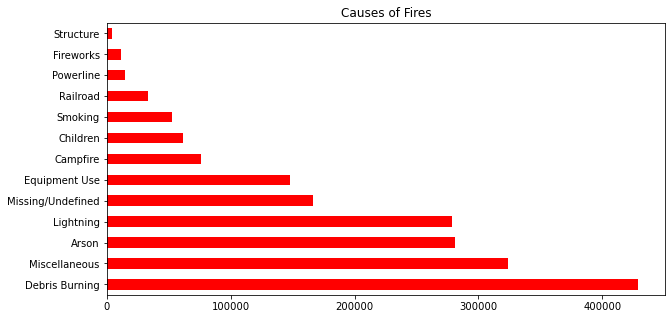

In [172]:
# number of fires among each category
fig,ax = plt.subplots(figsize=(10,5))
ax = data['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='red')
ax.set_title('Causes of Fires')

Text(0.5, 1.0, 'Number of fires within weeks')

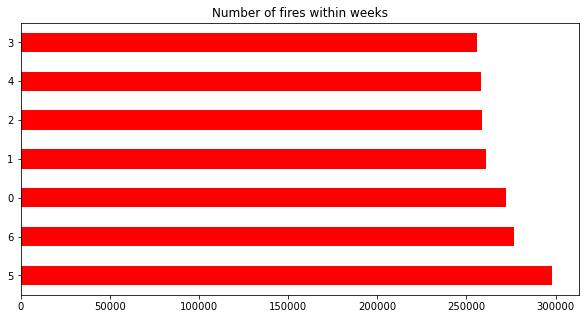

In [173]:
# number of fires everyday
fig,ax = plt.subplots(figsize=(10,5))
ax = data['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='red')
ax.set_title('Number of fires within weeks')

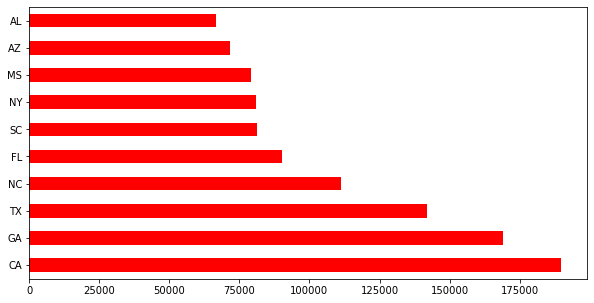

In [174]:
# 10 states that have most of the fires
fig,ax=plt.subplots(figsize=(10,5))
ax=data['STATE'].value_counts().head(10).plot(kind='barh',color='red')

# Pre-process for machine learning

In [175]:
# label encode
encoder = preprocessing.LabelEncoder()
data['STAT_CAUSE_DESCR'] = encoder.fit_transform(data['STAT_CAUSE_DESCR'])
data['STATE'] = encoder.fit_transform(data['STATE'])
data['DAY_OF_WEEK'] = encoder.fit_transform(data['DAY_OF_WEEK'])

In [176]:
# drop data column
data.drop('DATE',axis=1,inplace=True)

In [177]:
data.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK
0,2005,7,40.036944,-121.005833,4,2453403.5,0.10,2,2
1,2004,6,38.933056,-120.404444,4,2453137.5,0.25,5,2
2,2004,3,38.984167,-120.735556,4,2453156.5,0.10,5,0
3,2004,6,38.559167,-119.913333,4,2453184.5,0.10,6,0
4,2004,6,38.559167,-119.933056,4,2453184.5,0.10,6,0


In [178]:
# to get X and Y values
X = data.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = data['STAT_CAUSE_DESCR'].values

In [179]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [180]:
rf = ske.RandomForestClassifier(n_estimators=50)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.5799801467720779


# Reduce the number of labels

In [181]:
# function for call-back
# to set label for each cause
def set_label(cas):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cas in natural:
        cause = 1
    elif cas in accidental:
        cause = 2
    elif cas in malicious:
        cause = 3
    else:
        cause = 4
    return cause
data['LABEL'] = df['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
data = data.drop('STAT_CAUSE_DESCR',axis=1)
data.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK,LABEL
0,2005,40.036944,-121.005833,4,2453403.5,0.10,2,2,4
1,2004,38.933056,-120.404444,4,2453137.5,0.25,5,2,1
2,2004,38.984167,-120.735556,4,2453156.5,0.10,5,0,2
3,2004,38.559167,-119.913333,4,2453184.5,0.10,6,0,1
4,2004,38.559167,-119.933056,4,2453184.5,0.10,6,0,1


In [182]:
# Random-forest for reduced label
X = data.drop(['LABEL'], axis=1).values
y = data['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=50)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.701338320275109


# Prediction for single cause

In [183]:
df_arson = rf_data.copy()

In [184]:
rf_data.STAT_CAUSE_DESCR.unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

In [185]:
df_arson.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,2
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,2
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,0
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,0
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,0


In [187]:
# Arson
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
df_arson['ARSON'] = df_arson['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x))
df_arson.drop('DATE',axis=1,inplace=True)
df_arson.drop('STATE',axis=1,inplace=True)
df_arson.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_arson.drop('FIRE_SIZE',axis=1,inplace=True)
df_arson.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_arson['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_arson.drop(['ARSON'], axis=1).values
y = df_arson['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.8849310454851632


In [190]:
# Lightning
df_light = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Lightning':
        label = 1
    return label
df_light['Lightning'] = df_light['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_light.drop('DATE',axis=1,inplace=True)
df_light.drop('STATE',axis=1,inplace=True)
df_light.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_light.drop('FIRE_SIZE',axis=1,inplace=True)
df_light.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_light['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_light.drop(['Lightning'], axis=1).values
y = df_light['Lightning'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9477221966178608


In [191]:
# Miscellaneous
df_misc = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Miscellaneous':
        label = 1
    return label
df_misc['Miscellaneous'] = df_misc['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_misc.drop('DATE',axis=1,inplace=True)
df_misc.drop('STATE',axis=1,inplace=True)
df_misc.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_misc.drop('FIRE_SIZE',axis=1,inplace=True)
df_misc.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_misc['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_misc.drop(['Miscellaneous'], axis=1).values
y = df_misc['Miscellaneous'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.856881270606587


In [192]:
# Debris Burning
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Debris Burning':
        label = 1
    return label
df_cause['Debris Burning'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Debris Burning'], axis=1).values
y = df_cause['Debris Burning'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.8089410430035098


In [193]:
# Equipment Use
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Equipment Use':
        label = 1
    return label
df_cause['Equipment Use'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Equipment Use'], axis=1).values
y = df_cause['Equipment Use'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9253731343283582


In [194]:
# Missing/Undefined
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Missing/Undefined':
        label = 1
    return label
df_cause['Missing/Undefined'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Missing/Undefined'], axis=1).values
y = df_cause['Missing/Undefined'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9757790619349807


In [195]:
# Campfire
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Campfire':
        label = 1
    return label
df_cause['Campfire'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Campfire'], axis=1).values
y = df_cause['Campfire'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9622239160492077


In [196]:
# Children
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Children':
        label = 1
    return label
df_cause['Children'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Children'], axis=1).values
y = df_cause['Children'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9683624632183501


In [197]:
# Smoking
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Smoking':
        label = 1
    return label
df_cause['Smoking'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Smoking'], axis=1).values
y = df_cause['Smoking'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9714858013968164


In [198]:
# Railroad
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Railroad':
        label = 1
    return label
df_cause['Railroad'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Railroad'], axis=1).values
y = df_cause['Railroad'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9854947353493814


In [200]:
# Fireworks
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Fireworks':
        label = 1
    return label
df_cause['Fireworks'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Fireworks'], axis=1).values
y = df_cause['Fireworks'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9953681710213776


In [205]:
# Structure
df_cause = rf_data.copy()
def set_label(cause):
    label = 0
    if cause == 'Structure':
        label = 1
    return label
df_cause['Structure'] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
df_cause.drop('DATE',axis=1,inplace=True)
df_cause.drop('STATE',axis=1,inplace=True)
df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
df_cause.dropna(inplace=True)
encoder = preprocessing.LabelEncoder()
df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
X = df_cause.drop(['Structure'], axis=1).values
y = df_cause['Structure'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
rf = ske.RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
print(rf.score(X_test,y_test))

0.9979349097741695


In [206]:
def set_label(cause):
    label = 0
    if cause == 'Railroad':
        label = 1
    return label

In [207]:
# function for all of them
def random_forest(cause):
    df_cause = rf_data.copy()
    df_cause[cause] = df_cause['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x))
    df_cause.drop('DATE',axis=1,inplace=True)
    df_cause.drop('STATE',axis=1,inplace=True)
    df_cause.drop('STAT_CAUSE_DESCR',axis=1,inplace=True)
    df_cause.drop('FIRE_SIZE',axis=1,inplace=True)
    df_cause.dropna(inplace=True)
    encoder = preprocessing.LabelEncoder()
    df_cause['DAY_OF_WEEK'] = encoder.fit_transform(df_arson['DAY_OF_WEEK'])
    X = df_cause.drop([cause], axis=1).values
    y = df_cause[cause].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
    rf = ske.RandomForestClassifier(n_estimators=200)
    rf = rf.fit(X_train, y_train)
    print(rf.score(X_test,y_test))